In [212]:
# Data Libraries

import numpy as np
import math
import pandas as pd
import re
from numpy import dot
from numpy.linalg import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
from time import sleep
from tqdm import tqdm
from sklearn.decomposition import NMF
import umap
import seaborn as sb
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore") 

In [3]:
import os

# getting all sample cases
all_files = os.listdir('C:/Users/jono_/UniWork/Research Project 2023')
sample_files = list(filter(lambda f: f.endswith('a.csv'), all_files))
sample_files

['generated_dataset_0a.csv',
 'generated_dataset_1a.csv',
 'generated_dataset_2a.csv',
 'generated_dataset_3a.csv',
 'generated_dataset_4a.csv']

In [4]:
# SBS signatures
sigs = pd.read_csv('signatures_ordered.csv')
sigs_names = sigs.columns[1:]
sigs = sigs[sigs.columns[1:]]

In [5]:
# function to convert counts to individual for resampling
def counts_for_q(sample):
    sample_q_counts = []
    for i in sample:
        g_q_types = []
        count = 0
        for y in range(len(i)):
            g_q_types.extend([count for z in range(i[y].astype(np.int64))])
            count += 1
        sample_q_counts.append(g_q_types)
    
    return sample_q_counts

In [ ]:
def cosine_sim(a, b):
    return dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [7]:
def k_means_cos(n_clusters, nmf_sigs):
    max_iterations = 1000
    np.random.seed(1234)
    cluster_centroids = nmf_sigs[np.random.choice(len(nmf_sigs), n_clusters,
                                replace = False)]
    cluster_labels = [0]*len(nmf_sigs)
    
    for i in range(max_iterations):
        cluster_labels_old = cluster_labels
        for a in range(len(nmf_sigs)):
            cos_sim = [cosine_sim(nmf_sigs[a], cluster_centroids[b]) for b
                       in range(len(cluster_centroids))]
            cluster_labels[a] = int(cos_sim.index(np.max(cos_sim)))
            
        new_centroids = np.array([nmf_sigs[[x for x in range(len(cluster_labels))
                        if cluster_labels[x] == n]].mean(axis=0)
                        for n in range(n_clusters)])
        
        difference = [np.absolute(cluster_centroids[y] - new_centroids[y]).sum() 
                      for y in range(len(cluster_centroids))]
        
        if all(y <= 1e-10 for y in difference) == True:
            break
        
        cluster_centroids = new_centroids
            
    return cluster_labels, cluster_centroids

In [8]:
def cluster_sil_width_stats(score, cluster_labels):
    temp = pd.DataFrame([score, cluster_labels]).T
    temp.columns = ['score', 'cluster']
    cluster_widths = []
    
    for i in np.unique(cluster_labels):
        b = temp.loc[temp['cluster'] == i]
        cluster_widths.append(np.array(b['score']))

    return cluster_widths

In [9]:
def intra_cluster_distances(nmf_sigs, cluster_labels):
    temp = pd.DataFrame(nmf_sigs)
    temp['cluster'] = cluster_labels
    intra_distances = []
    
    for i in np.unique(cluster_labels):
        b = temp.loc[temp['cluster'] == i]
        b = np.array(b.drop(columns = 'cluster'))
        temp2 = np.array(cosine_distances(b))
        intra_distances.append([np.mean(i) for i in temp2])
        
    return intra_distances

In [10]:
def inter_cluster_distances(nmf_sigs, cluster_labels):
    temp = pd.DataFrame(nmf_sigs)
    temp['cluster'] = cluster_labels
    
    inter_cd = []
    
    for i in range(len(temp['cluster'].unique())):
        temp2 = []
        b = temp.loc[temp['cluster'] == i]
        c = temp.loc[temp['cluster'] != i]
        b = np.array(b.drop(columns = 'cluster'))
        c = np.array(c.drop(columns = 'cluster'))
        for y in b:
            temp2.append(np.mean([1-cosine_sim(y, f) for f in c]))
        inter_cd.append(temp2)
    return(inter_cd)

In [11]:
def sil_width(nmf_sigs, cluster_labels):
    # calculating intra_cluster cosine distances for each cluster
    intra_cluster = intra_cluster_distances(nmf_sigs, cluster_labels)
    cosine_dist = cosine_distances(nmf_sigs)
    
    # inter cluster distances
    inter_cluster = inter_cluster_distances(nmf_sigs, cluster_labels)
    
    # calculates silhouette score for every signature
    sil_score = silhouette_samples(cosine_dist, cluster_labels, metric = 'cosine')
    
    # calculating cluster silhouete widths
    cluster_sil_widths = cluster_sil_width_stats(sil_score, cluster_labels)
    
    return([intra_cluster, cluster_sil_widths, inter_cluster])

In [12]:
def linear_combination_model(sample, sigs):
    sigs = sigs.select_dtypes(include=np.number)
    # samp to store contributions of each sbs signature for each resample
    sigs_contributions = []
    
    n_sigs = 79
    matrix = np.array(sigs.values.tolist())
    
    for i in sample:
        c0 = np.ones((n_sigs, 1))/n_sigs
        
        def cost_function(c):
            #return np.abs(matrix @ c - i).sum()
            return np.linalg.norm(matrix @ c - i)
        
        bnds = [(0, 1)]*n_sigs
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
        res = minimize(cost_function, c0, bounds = bnds, constraints = cons, tol = 1e-10)
        # adding sbs contributions to final result
        sigs_contributions.append(res.x)
        
    return sigs_contributions

In [396]:
def lr_stats2(metric, scs):    # linear combination model and stats
    X_with_intercept = sm.add_constant(scs)
    model = sm.OLS(metric, X_with_intercept).fit()
    print(model.summary())
    
    p_value = model.pvalues[1]
    r_squared = model.rsquared
    standard_error_slope = model.bse[1]
    y_pred = model.predict(X_with_intercept)
    mse = mean_squared_error(metric, y_pred)
    
    intercept = model.params[0]
    slope = model.params[1]
    
    conf = model.conf_int()
    conf_ = []
    for i in conf:
        for y in i:
            conf_.append(round(y, 5))
    
    stats = [r_squared, p_value, standard_error_slope, mse, conf_[:2], conf_[2:]]
    
    for i in range(len(stats[:4])):
        stats[i] = round(stats[i], 5)
        
    return(stats, model, intercept, slope, y_pred)

In [45]:
# Code but only solving for 1 iteration of n_components
reconstruction_error_ = []
reconstruction_error_percentage_ = []
intra_cluster_distance_ = []
silhouette_widths_ = []
Cosine_similarities_ = []
Linear_combination_results_ = []
nmf_sets = []
indexes = []

for _ in tqdm(sample_files):
    # Loading samples
    samples = pd.read_csv(_)
    samples_for_pp = np.array(samples.values.tolist())
    
    # Dimensonality reduction and Monte-Carlo Bootstrap resampling
    index = [i for i in range(96) if sum(samples_for_pp)[i] > sum(sum(samples_for_pp))*0.01]
    indexes.append(index)

    samples_for_resample = np.array(samples[samples.columns[index]].values.tolist())
    samples_for_resample

    sample_q_counts = []
    for i in samples_for_resample:
        samp_i = []
        for y in range(len(i)):
            samp_i.extend([y]*(i[y]).astype(np.int64))
        sample_q_counts.append(samp_i)
        
    n_resamples = 400
    bootstrapped_samples_nmf = []

    for y in range(n_resamples):
        sample_nmf_bs = []
        for i in sample_q_counts:
            boot = resample(i, replace = True, n_samples = len(i))
            samp = [boot.count(i) for i in range(len(index))]
            sample_nmf_bs.append(samp)
        bootstrapped_samples_nmf.append(sample_nmf_bs)

    bootstrapped_samples_nmf = np.array(bootstrapped_samples_nmf)
    
    print(_,'Dimensionality Reduction and Monte-Carlo Bootstrap Resampling Completed...')
    
    # Preprocessing to get probability matrix
    
    samples_bs = []
    for y in bootstrapped_samples_nmf:
        samples_bs.append([np.divide(y[i], sum(y[i])) for i in range(len(y))])

    samples_bs = np.array(samples_bs)
    
    # n_components to solve for
    n_comp = range(2,6)
    #n_comp = [3]
    
    nmf_signatures = []
    nmf_exposures = []
    recon_error_percentage = []
    recon_error = []

    for n in n_comp:
        temp1 = []
        temp2 = []
        exposures = []
        signatures = []

        nmf = NMF(n_components=n, max_iter=1000000,
            init = 'nndsvda', random_state=1234,
            tol = 1e-7, beta_loss='frobenius')

        for i in range(len(samples_bs)):
            nmf.fit(samples_bs[i])
            exposures.extend([y for y in nmf.transform(samples_bs[i])])
            signatures.extend([y for y in nmf.components_])
            temp1.append(nmf.reconstruction_err_)
            temp2.append(nmf.reconstruction_err_/np.linalg.norm(samples_bs[i]))
            if i % 100 == 0:
                print(i)
        
        nmf_signatures.append(signatures)
        nmf_exposures.append(exposures)
        recon_error.append(temp1)
        recon_error_percentage.append(temp2)
        
    reconstruction_error_.append(recon_error)
    reconstruction_error_percentage_.append(recon_error_percentage)
    nmf_sets.append(nmf_signatures)
        
    print(_,'NMF Executed...')

  0%|          | 0/5 [00:00<?, ?it/s]

generated_dataset_0a.csv Dimensionality Reduction and Monte-Carlo Bootstrap Resampling Completed...
0
100
200
300
0
100
200
300
0
100
200
300
0
100
200
300


 20%|██        | 1/5 [12:14<48:58, 734.74s/it]

generated_dataset_0a.csv NMF Executed...
generated_dataset_1a.csv Dimensionality Reduction and Monte-Carlo Bootstrap Resampling Completed...
0
100
200
300
0
100
200
300
0
100
200
300
0
100
200
300


 40%|████      | 2/5 [22:10<32:38, 652.76s/it]

generated_dataset_1a.csv NMF Executed...
generated_dataset_2a.csv Dimensionality Reduction and Monte-Carlo Bootstrap Resampling Completed...
0
100
200
300
0
100
200
300
0
100
200
300
0
100
200
300


 60%|██████    | 3/5 [35:44<24:13, 726.54s/it]

generated_dataset_2a.csv NMF Executed...
generated_dataset_3a.csv Dimensionality Reduction and Monte-Carlo Bootstrap Resampling Completed...
0
100
200
300
0
100
200
300
0
100
200
300
0
100
200
300


 80%|████████  | 4/5 [50:02<12:58, 778.27s/it]

generated_dataset_3a.csv NMF Executed...
generated_dataset_4a.csv Dimensionality Reduction and Monte-Carlo Bootstrap Resampling Completed...
0
100
200
300
0
100
200
300
0
100
200
300
0
100
200
300


100%|██████████| 5/5 [1:49:52<00:00, 1318.43s/it]

generated_dataset_4a.csv NMF Executed...


pd.DataFrame(reconstruction_error_).to_csv('post_nmf_data_re.csv', index=False)
pd.DataFrame(reconstruction_error_percentage_).to_csv('post_nmf_data_rep.csv', index=False)
pd.DataFrame(nmf_sets).to_csv('post_nmf_data_nmfsets.csv', index=False)
pd.DataFrame(indexes).to_csv('post_nmf_data_indexes.csv', index=False)

In [127]:
intra_cluster_distance_ = []
silhouette_widths_ = []
Cosine_similarities_ = []
Linear_combination_results_ = []
sil_width_char_all = []
extracted_centroids = []
sets = []

for nmf_signatures in tqdm(nmf_sets):
    cluster_final = []
    cluster_centers_final = []
    sil_width_char = []

    for y in range(len(nmf_signatures)):
        nmf_sigs = nmf_signatures[y]
        n_clusters = int(len(nmf_sigs)/n_resamples)
        
        # converting all signatures so that they are = 100%.
        for i in range(len(nmf_sigs)):
            nmf_sigs[i] = np.multiply(nmf_sigs[i],(1.0/sum(nmf_sigs[i])))
        
        nmf_sigs = np.array(nmf_sigs)
        
        clusters, cluster_centers = k_means_cos(n_clusters, nmf_sigs)
        
        if y == 1:
            sets.append([nmf_sigs, clusters])
        
        # Storing cluster centers and clusters
        cluster_final.append(clusters)
        cluster_centers_final.append(cluster_centers)
        
        nmf_sigs = pd.DataFrame(nmf_sigs)
        
        sil_width_char.append(sil_width(nmf_sigs, clusters)) # provides [intra for all sigs in cluster, sil for all sigs in cluster]
        
    sil_width_char_all.append(sil_width_char)
    extracted_centroids.append(cluster_centers_final[1])

100%|██████████| 5/5 [04:08<00:00, 49.79s/it]


----------

### Reconstruction Error

,mean,std,min,25%,50%,75%,max
Sample 1,0.123786,0.002177,0.117313,0.122238,0.123823,0.125249,0.131230
Sample 2,0.151760,0.001672,0.146981,0.150599,0.151663,0.152826,0.157527
Sample 3,0.127564,0.001286,0.124004,0.126659,0.127454,0.128465,0.131096
Sample 4,0.146144,0.001185,0.142922,0.145295,0.146134,0.146844,0.150302
Sample 5,0.044500,0.000480,0.043400,0.044179,0.044490,0.044811,0.045888


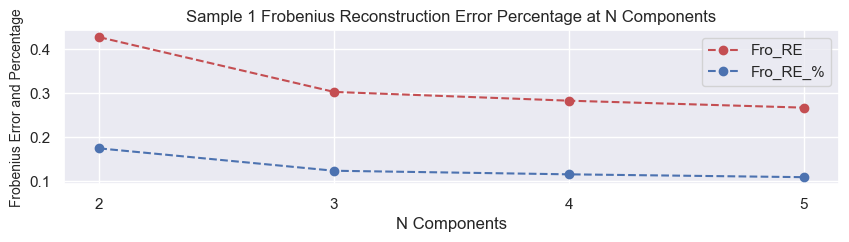

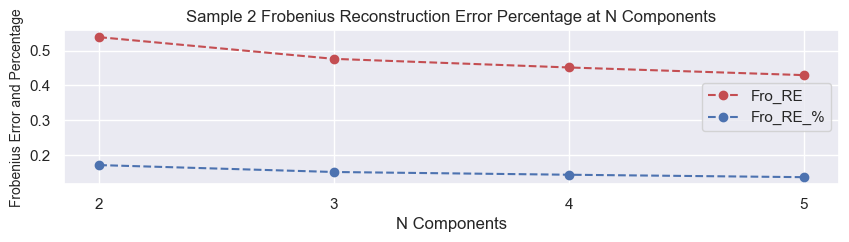

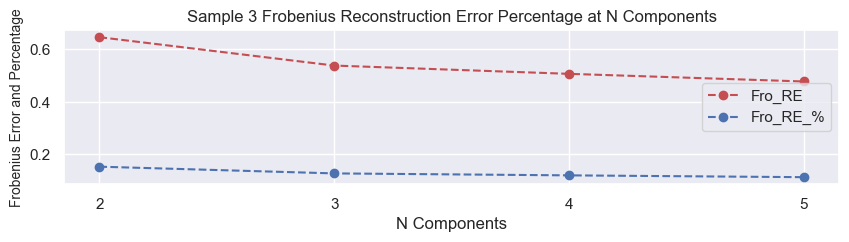

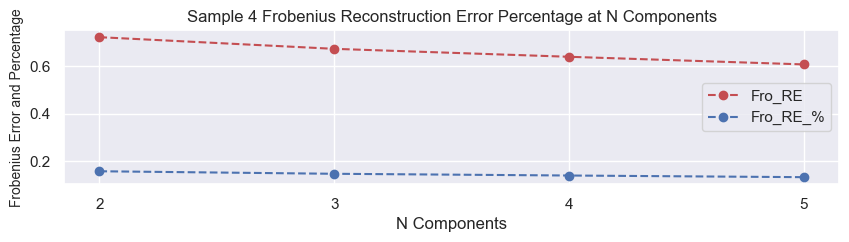

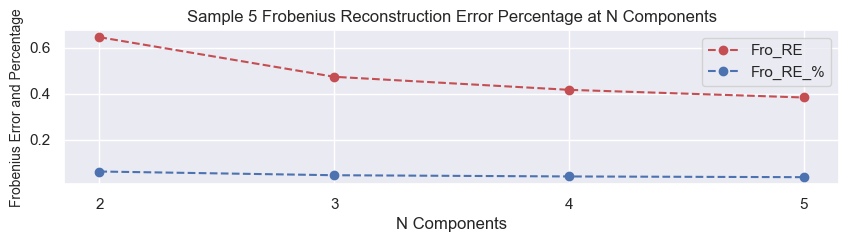

In [425]:
# Summary Statistics
REP = pd.DataFrame()
REP['Sample 1'] = pd.DataFrame(reconstruction_error_percentage_[0][1]).describe()
REP['Sample 2'] = pd.DataFrame(reconstruction_error_percentage_[1][1]).describe()
REP['Sample 3'] = pd.DataFrame(reconstruction_error_percentage_[2][1]).describe()
REP['Sample 4'] = pd.DataFrame(reconstruction_error_percentage_[3][1]).describe()
REP['Sample 5'] = pd.DataFrame(reconstruction_error_percentage_[4][1]).describe()
REP = REP.T.drop(columns = 'count')
display(REP)

# Graphs
for i in range(len(reconstruction_error_)):
    a = pd.DataFrame(reconstruction_error_[i])
    b = pd.DataFrame(reconstruction_error_percentage_[i])
    warnings.filterwarnings("ignore")
    plt.figure(figsize = (10,2))
    ax = plt.subplot(111)
    plt.plot(n_comp, a.T.describe().T['mean'], '--bo', label = ('Fro_RE'), color = 'r')
    plt.plot(n_comp, b.T.describe().T['mean'], '--bo', label = ('Fro_RE_%'), color = 'b')
    plt.xticks(n_comp) # Redefining x-axis labels
    #plt.ylim(np.min(reconstruction_error_percentage_df[i].T.describe().T['mean'])-0.02,np.max(reconstruction_error_percentage_df[i].T.describe().T['mean'])+0.02)

    plt.legend()
    plt.xlabel('N Components')
    plt.ylabel('Frobenius Error and Percentage', fontsize = 10)
    plt.title('Sample '+str(i+1)+' Frobenius Reconstruction Error Percentage at N Components')
    plt.savefig('fro_plot'+str(i)+'.jpg',format='jpeg',dpi=200,bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     795.7
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          1.21e-147
Time:                        23:07:06   Log-Likelihood:                 4004.0
No. Observations:                2000   AIC:                            -8004.
Df Residuals:                    1998   BIC:                            -7993.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1526      0.001    108.645      0.0

,R2,P-value,Standard Error,MSE,Y Conf 95%,X Conf 95%
CS_FRE%,0.28482,0.0,0.00232,0.00107,"[0.14982, 0.15533]","[-0.0701, -0.06099]"


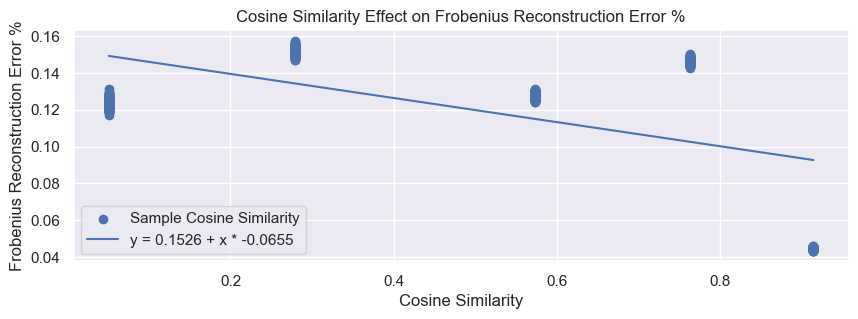

In [430]:
# Linear Regression
rep_ext = []
rep_cs = []
scs = np.array([0.051, 0.279, 0.573, 0.763, 0.914])

count = 0
for i in reconstruction_error_percentage_:
    rep_ext.extend(i[1])
    rep_cs.extend([scs[count] for y in range(len(i[1]))])
    count +=1

temp, model, intercept, slope, ypred = lr_stats2(rep_ext, rep_cs)
temp = pd.DataFrame(temp)
temp.columns = ['CS_FRE%']
temp = temp.T
temp.columns = ['R2', 'P-value', 'Standard Error', 'MSE', 'Y Conf 95%', 'X Conf 95%']
display(temp)

scs = np.array(rep_cs)
r = np.array(rep_ext)
r_pred = ypred
plt.figure(figsize = (10,3))
plt.scatter(scs, r,label = 'Sample Cosine Similarity', c = 'b')
i = str(round(intercept,4))
s = str(round(slope,4))
plt.plot(scs, r_pred, label = ('y = '+i+' + x * '+s))
plt.xlabel('Cosine Similarity')
plt.ylabel('Frobenius Reconstruction Error %')
plt.legend()
plt.title('Cosine Similarity Effect on Frobenius Reconstruction Error %')
plt.savefig('Fro_vs_CS.jpg',format='jpeg',dpi=200,bbox_inches='tight')

----------

### Silhouette Score Evaluation

In [48]:
# To get correct Silhouette Scores
sil_widths = []
for x in range(len(sil_width_char_all)):
    temp1 = []
    for i in range(len(sil_width_char_all[x])):
        temp2 = []
        for y in range(len(sil_width_char_all[x][i][0])):
            temp3 = []
            for z in range(len(sil_width_char_all[x][i][0][y])):
                temp3.append((sil_width_char_all[x][i][2][y][z]-sil_width_char_all[x][i][0][y][z])/max(sil_width_char_all[x][i][2][y][z],sil_width_char_all[x][i][0][y][z]))
            temp2.append(temp3)
        temp1.append(temp2)
    sil_widths.append(temp1)
    
sil_widths_final = []
for i in sil_widths:
    temp = []
    for y in i:
        temp.append(pd.DataFrame(y).T.describe())
    sil_widths_final.append(temp)

,mean,std,min,25%,50%,75%,max
Sample 1,0.992671,0.005736,0.958412,0.988049,0.994665,0.997704,0.998720
Sample 2,0.986493,0.014041,0.926339,0.972409,0.994540,0.997359,0.998466
Sample 3,0.991505,0.007532,0.814245,0.990019,0.992056,0.994444,0.996620
Sample 4,0.952886,0.044758,0.284157,0.938407,0.968141,0.975098,0.982668
Sample 5,0.957541,0.045497,0.735582,0.938081,0.978337,0.992590,0.996515


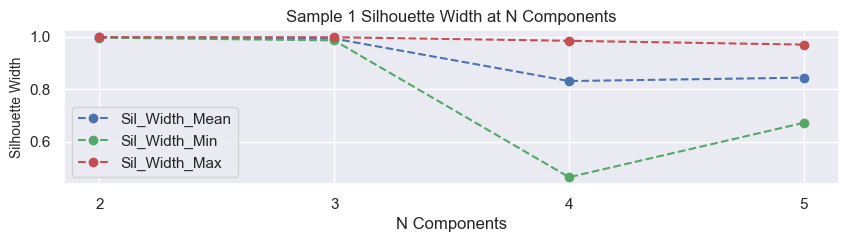

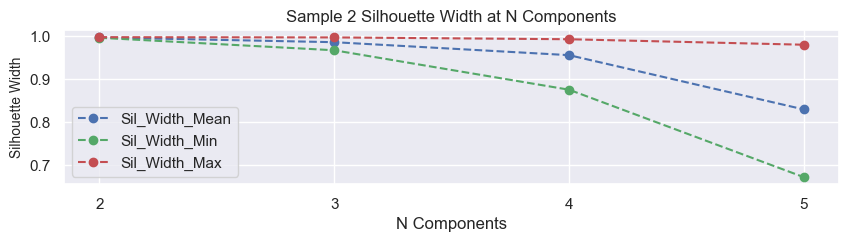

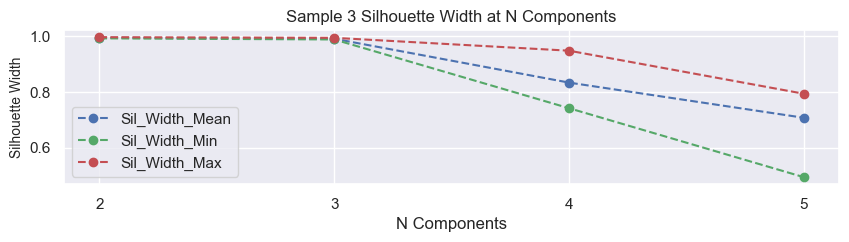

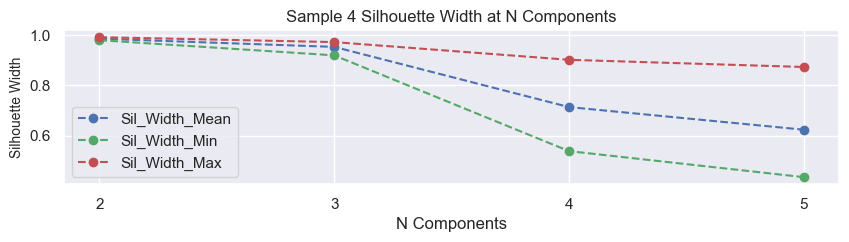

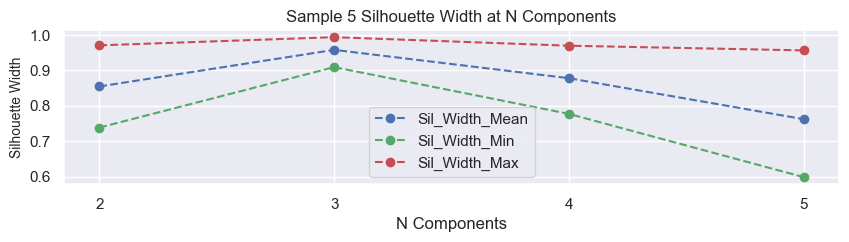

In [418]:
# Summary Statistics
temp = []
for i in range(len(sil_widths)):
    x = []
    for y in range(len(sil_widths[0][1])):
        x.extend(sil_widths[i][1][y])
    _mean = np.mean(x)
    _std = np.std(x)
    _min = np.min(x)
    _25 = np.percentile(x, 25)
    _50 = np.percentile(x, 50)
    _75 = np.percentile(x, 75)
    _max = np.max(x)
    temp.append([_mean,_std,_min,_25,_50,_75,_max])

SWD = pd.DataFrame(temp)
SWD.columns = ['mean','std','min','25%','50%','75%','max']
SWD = SWD.T
SWD.columns = ['Sample 1','Sample 2','Sample 3','Sample 4','Sample 5']
display(SWD.T)

# Graphs
count = 0
for i in sil_widths_final:
    a = []
    b = []
    c = []
    for y in i:
        a.append(np.mean(y.T['mean']))
        b.append(np.min(y.T['mean']))
        c.append(np.max(y.T['mean']))
        
    warnings.filterwarnings("ignore")
    plt.figure(figsize = (10,2))
    ax = plt.subplot(111)
    plt.plot(n_comp, a, '--bo', label = ('Sil_Width_Mean'), color = 'b')
    plt.plot(n_comp, b, '--bo', label = ('Sil_Width_Min'), color = 'g')
    plt.plot(n_comp, c, '--bo', label = ('Sil_Width_Max'), color = 'r')
    plt.xticks(n_comp) # Redefining x-axis labels
    
    plt.legend()
    plt.xlabel('N Components')
    plt.ylabel('Silhouette Width', fontsize = 10)
    plt.title('Sample '+str(count+1)+' Silhouette Width at N Components')
    plt.savefig('sil_w_plot'+str(count)+'.jpg',format='jpeg',dpi=200,bbox_inches='tight')
    count+=1


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     1255.
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          8.56e-250
Time:                        23:06:28   Log-Likelihood:                 12302.
No. Observations:                6000   AIC:                        -2.460e+04
Df Residuals:                    5998   BIC:                        -2.459e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9996      0.001   1294.288      0.

,R2,P-value,Standard Error,MSE,Y Conf 95%,X Conf 95%
CS_SWD,0.17304,0.0,0.00128,0.00097,"[0.99806, 1.00109]","[-0.04778, -0.04277]"


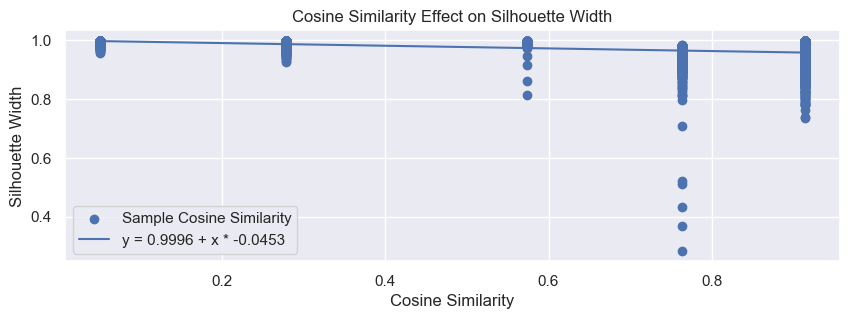

In [429]:
sw_ext = []
sw_cs = []
scs = np.array([0.051, 0.279, 0.573, 0.763, 0.914])

count = 0
for y in range(len(sil_widths)):  
    for i in range(len(sil_widths[y][1])):
        sw_ext.extend(sil_widths[y][1][i])
        sw_cs.extend([scs[count] for x in range(len(sil_widths[y][1][i]))])
    count+=1
    
print()
    
# Linear Regression
temp, model, intercept, slope, ypred = lr_stats2(sw_ext, sw_cs)
temp = pd.DataFrame(temp)
temp.columns = ['CS_SWD']
temp = temp.T
temp.columns = ['R2', 'P-value', 'Standard Error', 'MSE', 'Y Conf 95%', 'X Conf 95%']
display(temp)

scs = np.array(sw_cs)
r = np.array(sw_ext)
r_pred = ypred
plt.figure(figsize = (10,3))
plt.scatter(scs, r, label = 'Sample Cosine Similarity', c = 'b')
i = str(round(intercept,4))
s = str(round(slope,4))
plt.plot(scs, r_pred, label = ('y = '+i+' + x * '+s))
plt.xlabel('Cosine Similarity')
plt.ylabel('Silhouette Width')
plt.legend()
plt.title('Cosine Similarity Effect on Silhouette Width')
plt.savefig('SWD_vs_CS.jpg',format='jpeg',dpi=200,bbox_inches='tight')

----------

### Intra-Cluster Distance

In [231]:
inter = []
inter_all = []
intra = []
intra_all = []
for i in range(len(sil_width_char_all)):
    temp = []
    temp2 = []
    temp3 = []
    temp4 = []
    for y in range(len(sil_width_char_all[i][1][2])):
        temp.append(sil_width_char_all[i][1][2][y])
        temp2.extend(sil_width_char_all[i][1][2][y])
        temp3.append(sil_width_char_all[i][1][0][y])
        temp4.extend(sil_width_char_all[i][1][0][y])
    inter.append(temp)
    inter_all.append(temp2)
    intra.append(temp3)
    intra_all.append(temp4)

In [232]:
intraCD = pd.DataFrame()
intraCD['Sample 1'] = pd.DataFrame(intra_all[0]).describe()
intraCD['Sample 2'] = pd.DataFrame(intra_all[1]).describe()
intraCD['Sample 3'] = pd.DataFrame(intra_all[2]).describe()
intraCD['Sample 4'] = pd.DataFrame(intra_all[3]).describe()
intraCD['Sample 5'] = pd.DataFrame(intra_all[4]).describe()
intraCD = intraCD.T.drop(columns = 'count')
intraCD

,mean,std,min,25%,50%,75%,max
Sample 1,0.005634,0.004332,0.000971,0.001750,0.004116,0.009437,0.028545
Sample 2,0.009353,0.009549,0.001055,0.001802,0.003964,0.019410,0.045622
Sample 3,0.003452,0.002483,0.001558,0.002305,0.002988,0.004141,0.048102
Sample 4,0.015487,0.011658,0.005166,0.007736,0.009956,0.021984,0.104166
Sample 5,0.016057,0.015962,0.001214,0.002551,0.011614,0.022254,0.109920


In [88]:
interCD = pd.DataFrame()
interCD['Sample 1'] = pd.DataFrame(inter_all[0]).describe()
interCD['Sample 2'] = pd.DataFrame(inter_all[1]).describe()
interCD['Sample 3'] = pd.DataFrame(inter_all[2]).describe()
interCD['Sample 4'] = pd.DataFrame(inter_all[3]).describe()
interCD['Sample 5'] = pd.DataFrame(inter_all[4]).describe()
interCD = interCD.T.drop(columns = 'count')
interCD

,mean,std,min,25%,50%,75%,max
Sample 1,0.766845,0.023358,0.675020,0.751960,0.765663,0.780240,0.831758
Sample 2,0.697149,0.026409,0.575336,0.678520,0.696251,0.716418,0.782428
Sample 3,0.414119,0.055726,0.258953,0.350109,0.441678,0.457213,0.517483
Sample 4,0.327227,0.042122,0.139205,0.297909,0.319609,0.348775,0.546461
Sample 5,0.403382,0.093611,0.248548,0.335507,0.362760,0.485985,0.593531


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     657.9
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          9.22e-138
Time:                        23:10:54   Log-Likelihood:                 18710.
No. Observations:                6000   AIC:                        -3.742e+04
Df Residuals:                    5998   BIC:                        -3.740e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.000     15.762      0.0

,R2,P-value,Standard Error,MSE,Y Conf 95%,X Conf 95%
CS_Intra,0.09884,0.0,0.00044,0.00011,"[0.00366, 0.0047]","[0.0104, 0.01213]"
CS_Inter,0.78774,0.0,0.00348,0.00718,"[0.78532, 0.79356]","[-0.52561, -0.51198]"


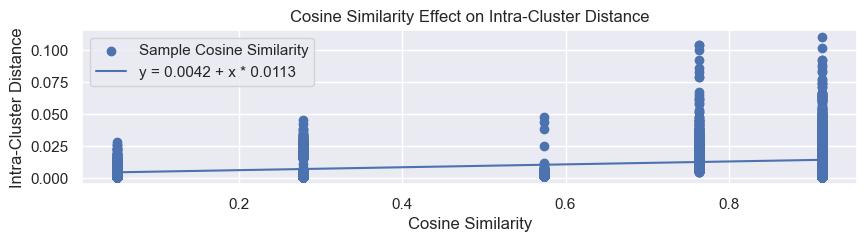

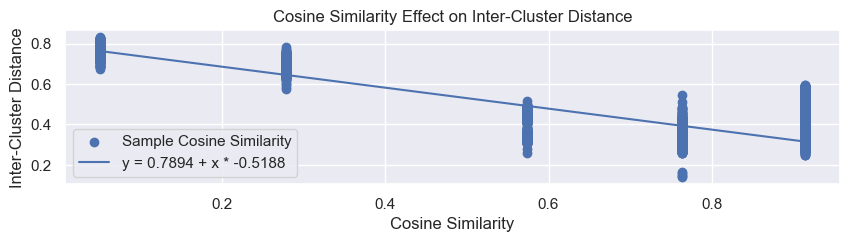

In [434]:
intra_ext = []
inter_ext = []
sw_cs = []
scs = np.array([0.051, 0.279, 0.573, 0.763, 0.914])

count = 0
for y in range(len(sil_widths)):
    intra_ext.extend(intra_all[y])
    inter_ext.extend(inter_all[y])    
    for i in range(len(sil_widths[y][1])):
        sw_ext.extend(sil_widths[y][1][i])
        sw_cs.extend([scs[count] for x in range(len(sil_widths[y][1][i]))])
    count+=1

# Summary Statistics
temp, model, intercept, slope, ypred = lr_stats2(intra_ext, sw_cs)
temp2, model2, intercept2, slope2, ypred2 = lr_stats2(inter_ext, sw_cs)
ss = pd.DataFrame([temp, temp2])
ss.columns = ['R2', 'P-value', 'Standard Error', 'MSE', 'Y Conf 95%', 'X Conf 95%']
ss = round(ss.T)
ss.columns = ['CS_Intra', 'CS_Inter']
display(ss.T)


scs = sw_cs
r_pred = ypred
r = np.array(intra_ext)
plt.figure(figsize = (10,2))
plt.scatter(scs, r, label = 'Sample Cosine Similarity', c = 'b')
i = str(round(intercept,4))
s = str(round(slope,4))
plt.plot(scs, r_pred, label = ('y = '+i+' + x * '+s))
plt.xlabel('Cosine Similarity')
plt.ylabel('Intra-Cluster Distance')
plt.legend()
plt.title('Cosine Similarity Effect on Intra-Cluster Distance')
plt.savefig('Intra_vs_CS.jpg',format='jpeg',dpi=200,bbox_inches='tight')

# Graphs
scs = sw_cs
r_pred = ypred2
r = np.array(inter_ext)
plt.figure(figsize = (10,2))
plt.scatter(scs, r, label = 'Sample Cosine Similarity', c = 'b')
i = str(round(intercept2,4))
s = str(round(slope2,4))
plt.plot(scs, r_pred, label = ('y = '+i+' + x * '+s))
plt.xlabel('Cosine Similarity')
plt.ylabel('Inter-Cluster Distance')
plt.legend()
plt.title('Cosine Similarity Effect on Inter-Cluster Distance')
plt.savefig('Inter_vs_CS.jpg',format='jpeg',dpi=200,bbox_inches='tight')

----------

### Cosine Distance

In [50]:
samp_cosine_similarities = [0.051, 0.279, 0.526, 0.763, 0.914]

temp = sets

centroid_final = []
cluster_final = []
for i in temp:
    nmf_sigs = np.array(i)
    n_clusters = int(3.0)
        
    clusters, cluster_centers = k_means_cos(n_clusters, nmf_sigs)
    #print(len(cluster_centers[0]))
    centroid_final.append(cluster_centers)
    cluster_final.append(clusters)

extracted_cs_mean = []
extracted_cs = []

# to here
es_sigs_final = []
count = 0
for i in centroid_final:
    #r = [i for i in range(96)] # delete after final version
    index = indexes[count]
    #index = resample(r, replace = False, n_samples = len(i[0])) # Delete after final version
    print(len(index))
        
    # Converting all extracted centroids back into 96 length vectors
    centroids_fin = np.array([[0.0]*96]*len(i))

    for y in range(len(i)):
        centroids_fin[y][index] = i[y]
        
    centroids_fin = pd.DataFrame(centroids_fin)
    es_sigs_final.append(centroids_fin)
    
    #display(centroids_fin)
    
    ext_cs = cosine_similarity(centroids_fin)

    # getting cosine similarity between extracted signatures
    temp = []
    for i in range(len(ext_cs)):
        temp2 = 0
        for j in range(len(ext_cs)):
            if i != j:
                temp2+=ext_cs[i,j]
        temp2 = temp2/(len(ext_cs)-1)
        temp.append(np.mean(temp2))
    extracted_cs.append(temp)
    extracted_cs_mean.append(np.mean(temp))
    count+=1

29
32
26
26
15


In [125]:
es_sigs_final[0]

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.0,0.0,0.0,0.0,0.309022,0.056814,0.042009,0.151036,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.003037,0.007565,0.003218,0.013201,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.013761,0.008338,0.003677,0.004380,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
cs_final = pd.DataFrame([extracted_cs_mean, samp_cosine_similarities])
cs_final.columns = ['Sample 1','Sample 2','Sample 3','Sample 4','Sample 5']
cs_final = cs_final.T
cs_final.columns = ['Extracted Sig CS', 'Sample Sig CS']
cs_final

,Extracted Sig CS,Sample Sig CS
Sample 1,0.233518,0.051
Sample 2,0.304526,0.279
Sample 3,0.587351,0.526
Sample 4,0.681679,0.763
Sample 5,0.601769,0.914


In [119]:
count = 1
for i in es_sigs_final:
    temp = cosine_similarity(np.array(i), np.array(sigs.T))
    temp = pd.DataFrame(temp)
    temp.columns = sigs_names
    temp = temp.T
    e = ['Extracted 1','Extracted 2','Extracted 3']
    temp.columns = e
    temp = temp.T
    temp = np.array(temp)
    print('Sample '+str(count)+':')
    for y in range(len(temp)):
        a = []
        print(e[y]+':')
        for j in range(len(temp[y])):
            if temp[y][j] > 0.8:
                print('\t'+sigs_names[j]+':', round(temp[y][j], 4))
    print()
    count +=1

Sample 1:
Extracted 1:
	SBS38: 0.9702
	SBS45: 0.8715
	SBS53: 0.838
Extracted 2:
	SBS6: 0.9847
	SBS15: 0.8598
Extracted 3:
	SBS12: 0.9924
	SBS26: 0.9286
	SBS37: 0.813

Sample 2:
Extracted 1:
	SBS10a: 0.8773
	SBS10c: 0.965
	SBS10d: 0.8521
	SBS56: 0.8996
Extracted 2:
	SBS6: 0.9745
	SBS15: 0.8463
Extracted 3:
	SBS25: 0.8459

Sample 3:
Extracted 1:
	SBS23: 0.8107
	SBS42: 0.9633
Extracted 2:
	SBS30: 0.9957
Extracted 3:
	SBS44: 0.9711

Sample 4:
Extracted 1:
	SBS4: 0.9705
	SBS29: 0.8303
	SBS45: 0.8422
	SBS95: 0.8691
Extracted 2:
	SBS24: 0.8226
	SBS29: 0.9578
	SBS95: 0.8355
Extracted 3:
	SBS8: 0.9168

Sample 5:
Extracted 1:
	SBS10d: 0.8144
	SBS18: 0.91
	SBS36: 0.9818
	SBS56: 0.8412
	SBS95: 0.8024
Extracted 2:
	SBS10a: 0.9446
	SBS10c: 0.8844
	SBS10d: 0.975
	SBS36: 0.8804
	SBS56: 0.9951
Extracted 3:
	SBS52: 0.9513



-------

### Linear Combination Model

In [154]:
len(sets[i][1])

1200

In [155]:
# converting all extracted SBS sigs to 96 length vectors
extracted_for_lcm = []

for i in range(len(sets)):
    index = indexes[i]
    extracted = np.array([[0.0]*96]*len(sets[i][0]))
    
    extracted = np.array(extracted)
    
    for y in range(len(extracted)):
        extracted[y][index] = sets[i][0][y]
    
    extracted = pd.DataFrame(extracted)
    extracted['cluster'] = sets[i][1]
    
    extracted_for_lcm.append(extracted)

In [156]:
extracted_for_lcm[0]

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,cluster
0,0.0,0.0,0.0,0.0,0.309742,0.058166,0.044934,0.150710,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.000000,0.004018,0.002247,0.014337,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.027548,0.010940,0.002381,0.010806,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.327647,0.057714,0.039427,0.159156,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.000000,0.012717,0.009557,0.014414,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0.0,0.0,0.0,0.0,0.000421,0.006931,0.003858,0.008057,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1196,0.0,0.0,0.0,0.0,0.005530,0.009114,0.001158,0.007526,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1197,0.0,0.0,0.0,0.0,0.305269,0.057508,0.041538,0.148143,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1198,0.0,0.0,0.0,0.0,0.000000,0.003613,0.001479,0.019085,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [157]:
df_n = []
for nmf_sigs_final in tqdm(extracted_for_lcm):
    df = []
    for i in range(len(nmf_sigs_final['cluster'].unique())):
        sigs_to_solve = nmf_sigs_final.loc[nmf_sigs_final['cluster'] == i]
        length = (len(sigs_to_solve.columns) - 1)
        sigs_to_solve = sigs_to_solve[sigs_to_solve.columns[:length]]
        sigs_to_solve = sigs_to_solve.values.tolist()

        sigs_contributions = linear_combination_model(sigs_to_solve, sigs)
        
        df.append(pd.DataFrame(sigs_contributions))
    df_n.append(df)

100%|██████████| 5/5 [07:15<00:00, 87.05s/it] 


In [204]:
count = 1
for i in df_n:
    cl = 1
    for y in i:
        temp = y.describe().T.drop(columns = ['count'])
        for i in temp.columns:
            temp[i] = round(temp[i], 4)
        temp.sort_values(by=['mean'])
        temp = temp[temp['mean'] > 0.05]
        print('                     Sample '+str(count)+': Cluster '+str(cl))
        display(temp.sort_values(by=['mean'], ascending=False).head(5))
        cl +=1
    count +=1

                     Sample 1: Cluster 1


,mean,std,min,25%,50%,75%,max
SBS38,0.7725,0.0252,0.7036,0.7553,0.7702,0.7870,0.8607
SBS6,0.1186,0.0272,0.0214,0.1021,0.1185,0.1376,0.1980
SBS12,0.0650,0.0270,0.0000,0.0490,0.0667,0.0842,0.1384


                     Sample 1: Cluster 2


,mean,std,min,25%,50%,75%,max
SBS6,0.8607,0.0457,0.7198,0.8289,0.8622,0.8944,0.9818


                     Sample 1: Cluster 3


,mean,std,min,25%,50%,75%,max
SBS12,0.937,0.036,0.8135,0.9157,0.9404,0.9651,1.0


                     Sample 2: Cluster 1


,mean,std,min,25%,50%,75%,max
SBS10c,0.4685,0.0378,0.3251,0.4438,0.4700,0.4949,0.5778
SBS10a,0.1742,0.0215,0.1132,0.1589,0.1732,0.1877,0.2556
SBS56,0.1435,0.0249,0.0712,0.1276,0.1432,0.1603,0.2169
SBS34,0.0880,0.0080,0.0659,0.0822,0.0877,0.0933,0.1167


                     Sample 2: Cluster 2


,mean,std,min,25%,50%,75%,max
SBS6,0.7638,0.0307,0.6896,0.7399,0.7614,0.7848,0.8489
SBS44,0.0541,0.0150,0.0034,0.0442,0.0546,0.0650,0.0930


                     Sample 2: Cluster 3


,mean,std,min,25%,50%,75%,max
SBS25,0.8566,0.0348,0.7028,0.8342,0.8622,0.8812,0.9297
SBS22,0.1032,0.0241,0.0317,0.0873,0.1012,0.1189,0.1910


                     Sample 3: Cluster 1


,mean,std,min,25%,50%,75%,max
SBS42,0.6999,0.0446,0.6070,0.6690,0.6948,0.7304,0.8839
SBS23,0.1110,0.0133,0.0729,0.1022,0.1104,0.1189,0.1637
SBS44,0.0744,0.0372,0.0000,0.0513,0.0792,0.1024,0.1621
SBS30,0.0594,0.0347,0.0000,0.0357,0.0591,0.0839,0.1499


                     Sample 3: Cluster 2


,mean,std,min,25%,50%,75%,max
SBS30,0.9894,0.0129,0.9202,0.9851,0.9936,0.9993,1.0


                     Sample 3: Cluster 3


,mean,std,min,25%,50%,75%,max
SBS44,0.98,0.0235,0.7172,0.9713,0.9833,0.9948,1.0


                     Sample 4: Cluster 1


,mean,std,min,25%,50%,75%,max
SBS4,0.4101,0.0878,0.0773,0.3544,0.4110,0.4671,0.6884
SBS29,0.3278,0.0819,0.0000,0.2838,0.3331,0.3773,0.6796
SBS45,0.2519,0.0438,0.1681,0.2273,0.2492,0.2711,0.6720


                     Sample 4: Cluster 2


,mean,std,min,25%,50%,75%,max
SBS29,0.8991,0.0404,0.494,0.8870,0.9075,0.9224,0.9642
SBS59,0.0865,0.0230,0.030,0.0704,0.0847,0.0987,0.1800


                     Sample 4: Cluster 3


,mean,std,min,25%,50%,75%,max
SBS8,0.9033,0.0589,0.5442,0.8816,0.9159,0.941,0.9903


                     Sample 5: Cluster 1


,mean,std,min,25%,50%,75%,max
SBS36,0.7280,0.2127,0.0,0.5960,0.7963,0.8878,0.9855
SBS10a,0.1139,0.1266,0.0,0.0000,0.0788,0.1924,0.5015
SBS45,0.0541,0.0311,0.0,0.0309,0.0551,0.0758,0.1558


                     Sample 5: Cluster 2


,mean,std,min,25%,50%,75%,max
SBS56,0.5786,0.0634,0.0000,0.5433,0.5924,0.6224,0.6865
SBS10a,0.3217,0.0344,0.2504,0.2979,0.3195,0.3406,0.5980
SBS52,0.0597,0.0265,0.0000,0.0421,0.0602,0.0790,0.1330


                     Sample 5: Cluster 3


,mean,std,min,25%,50%,75%,max
SBS52,0.9636,0.0676,0.5928,0.9548,1.0,1.0,1.0


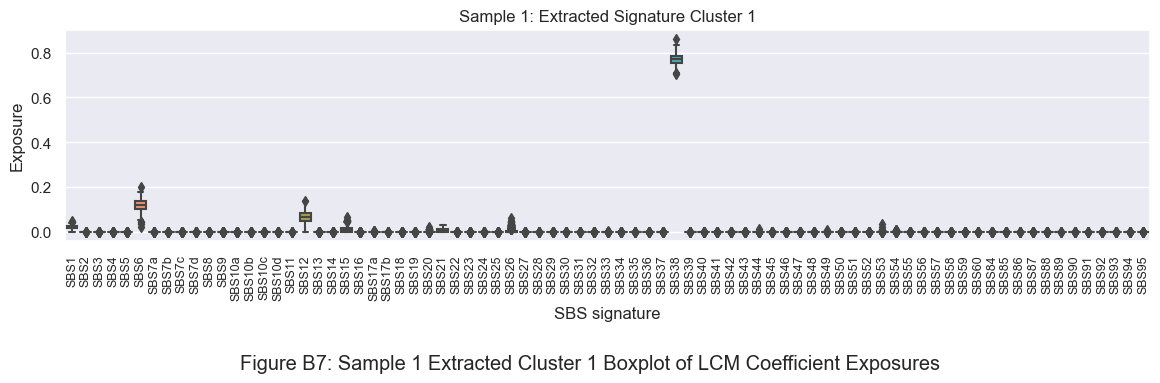

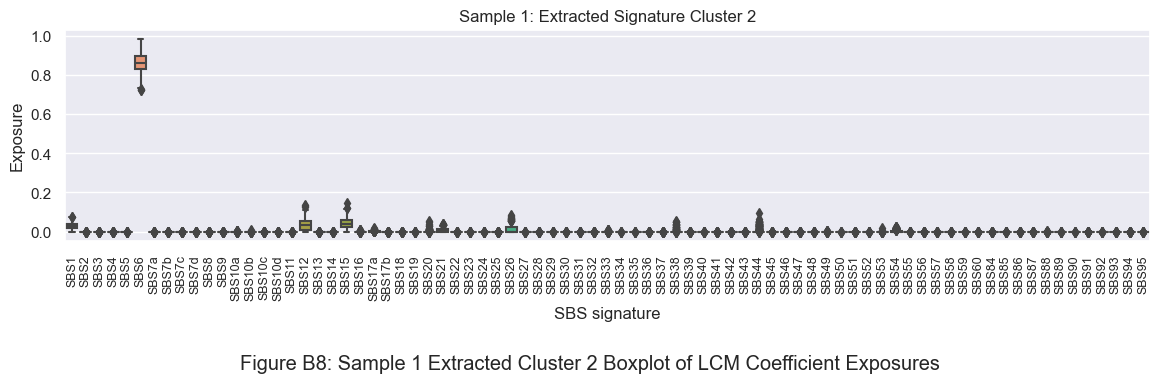

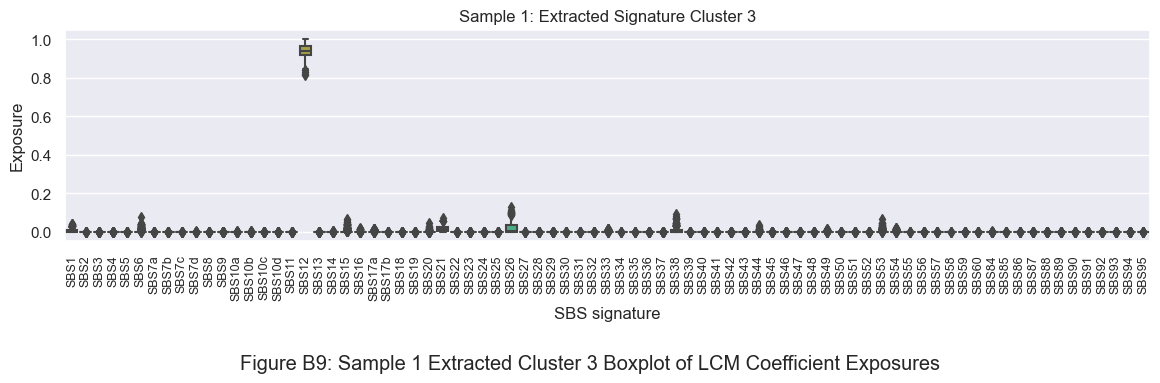

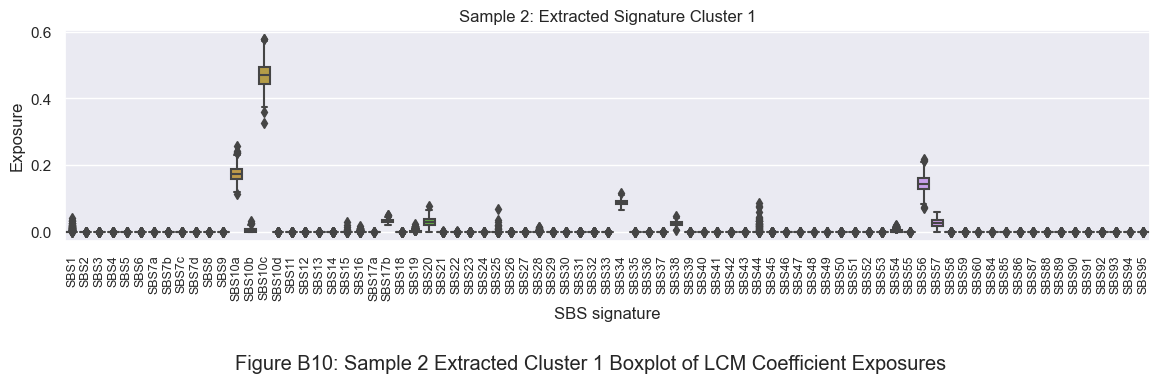

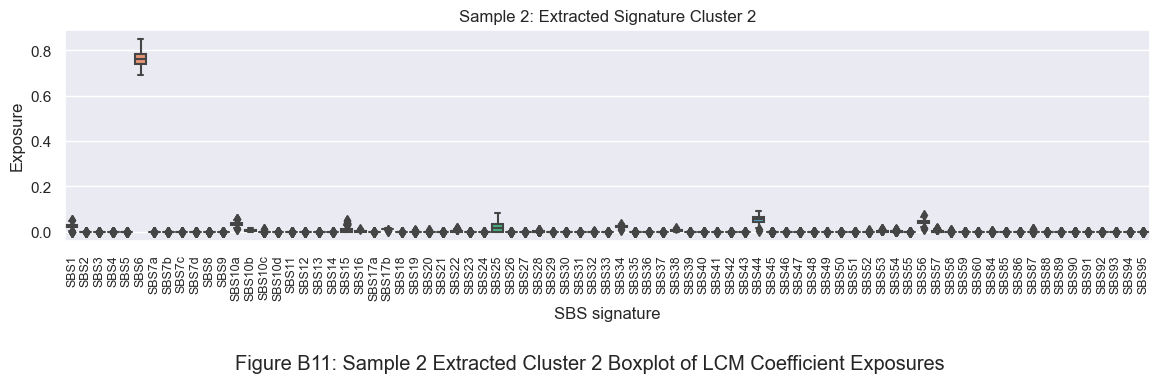

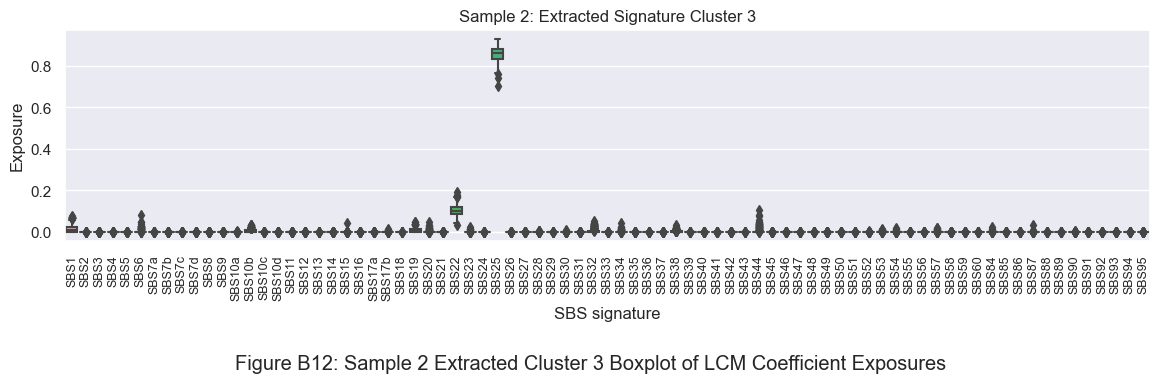

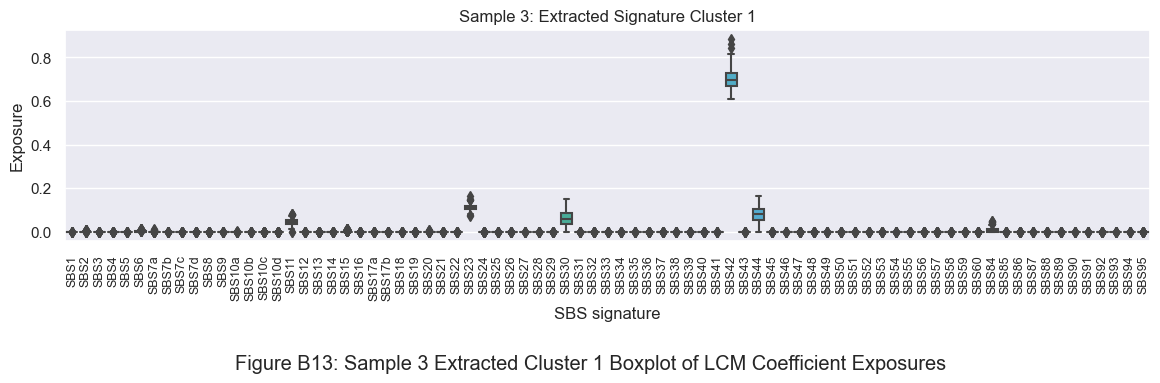

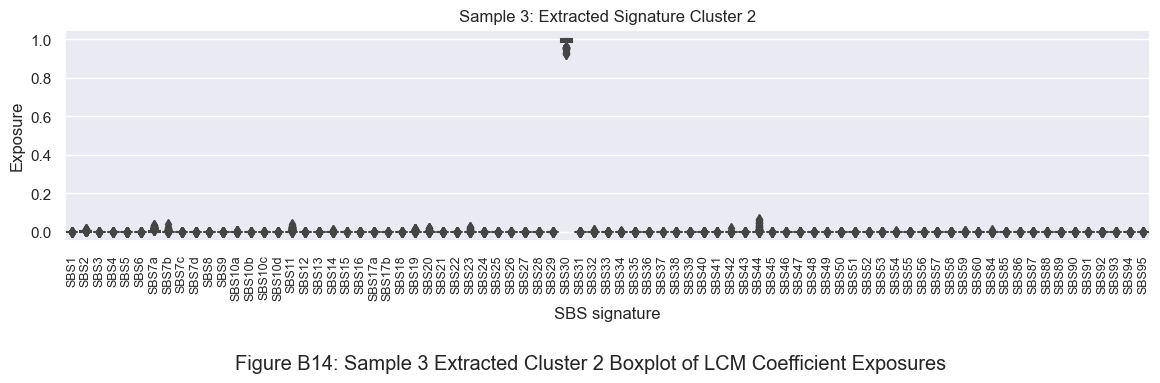

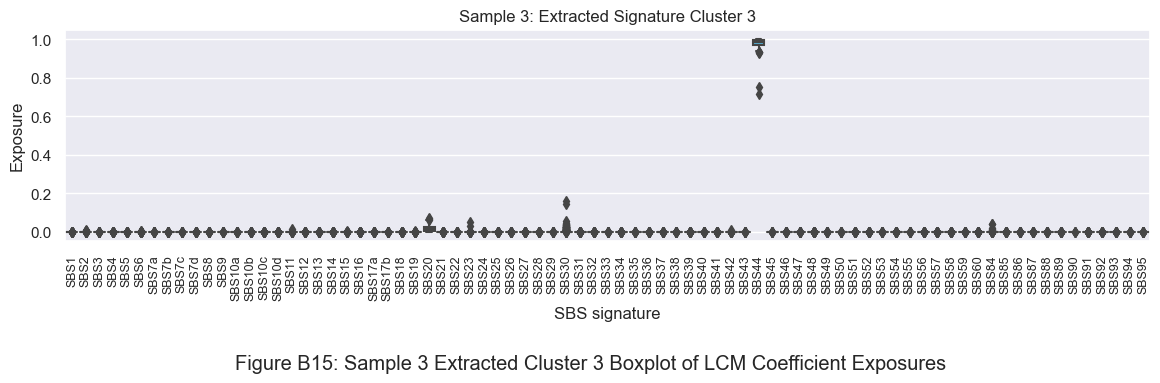

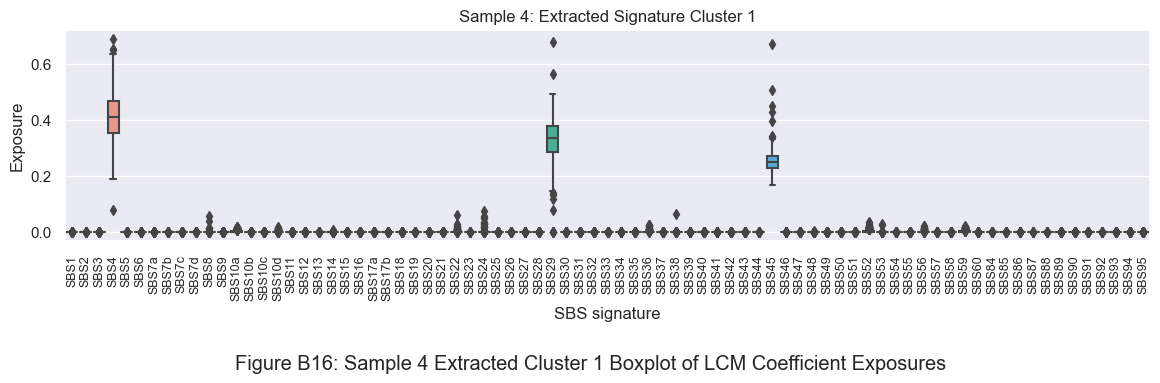

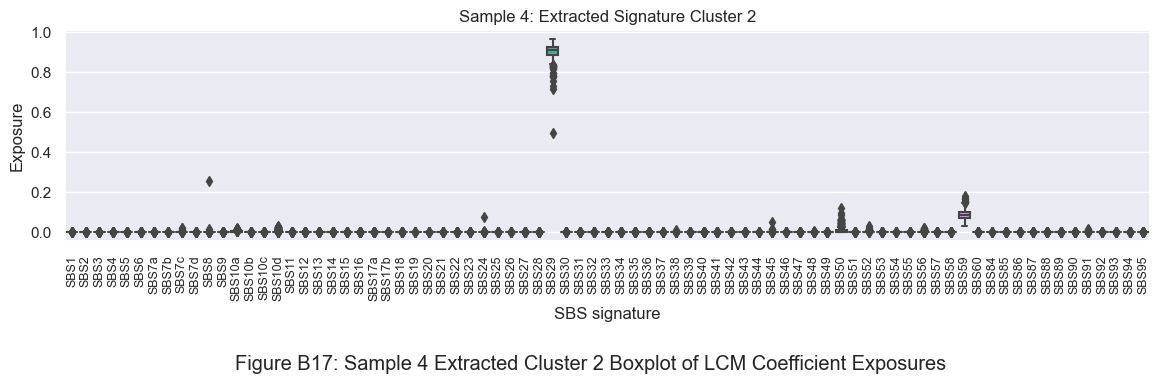

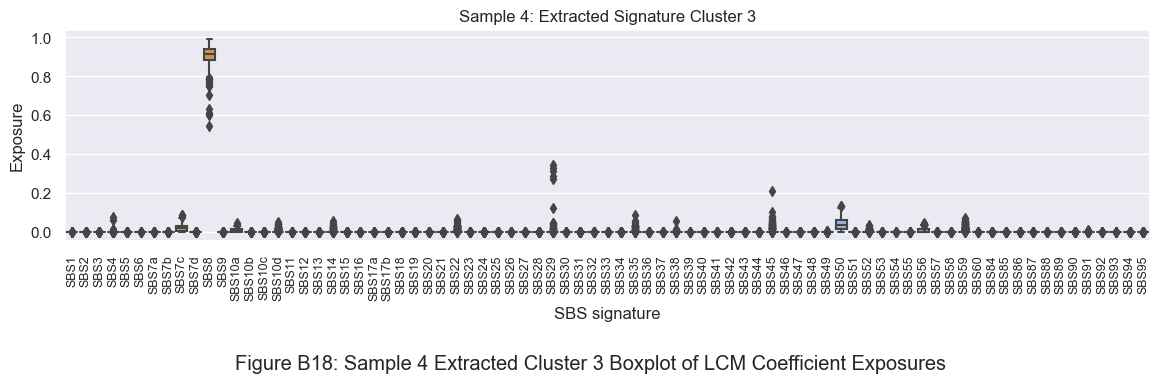

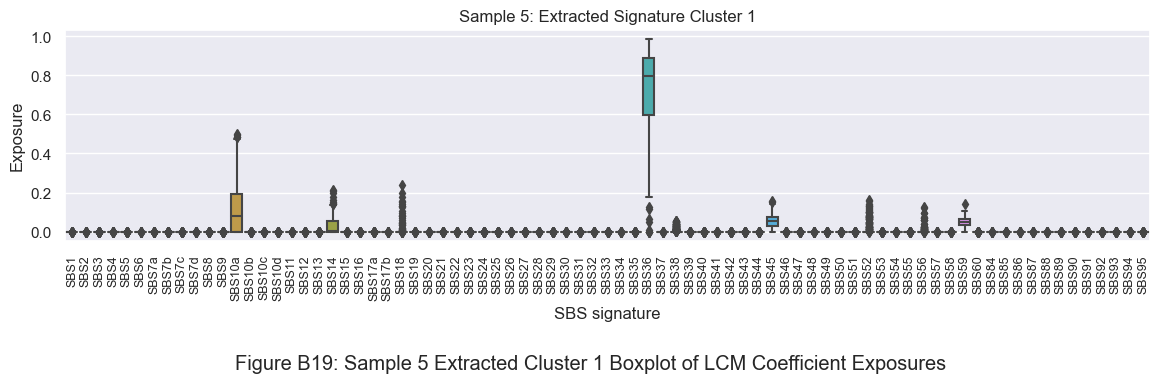

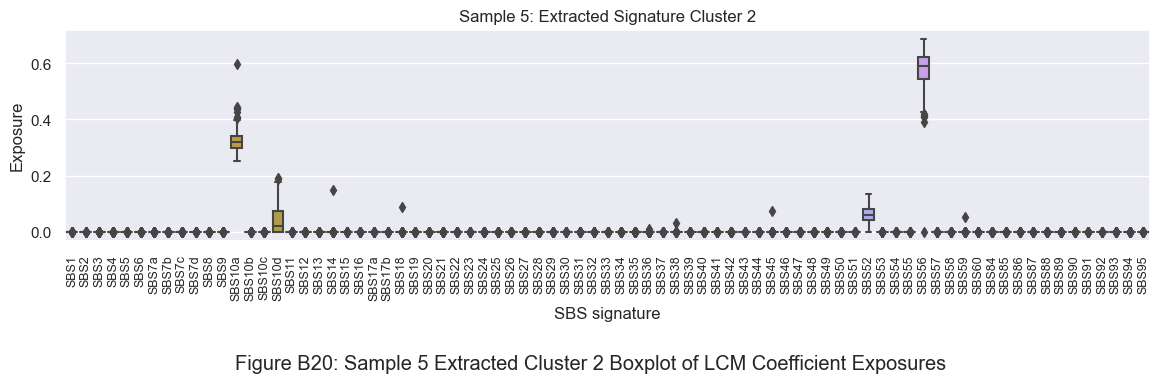

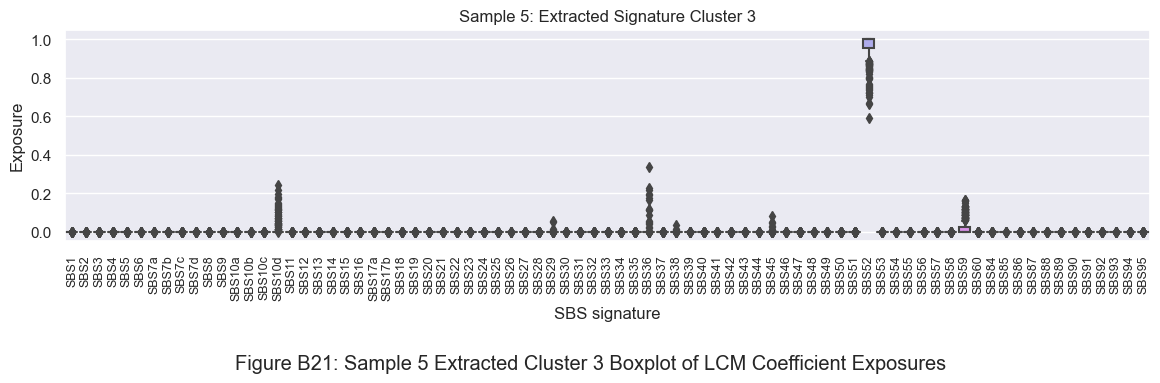

In [186]:
frange = 7
for i in range(len(df_n)):
    count = 0
    for df in df_n[i]:
        df.columns = sigs_names
        sb.set(rc={'figure.figsize':(14,2.75)})
        ax = sb.boxplot(data = df)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontdict={'fontsize':9})
        plt.ylabel(ylabel='Exposure')
        plt.xlabel(xlabel='SBS signature')
        plt.title('Sample '+str(i+1)+': Extracted Signature Cluster '+str(count+1))
        plt.suptitle('Figure B'+str(frange)+': Sample '+str(i+1)+' Extracted Cluster '+str(count+1) +' Boxplot of LCM Coefficient Exposures', y=-0.3)
        frange +=1
        plt.show()
        fig = ax.get_figure()
        fig.savefig('Sample'+str(i+1)+'es'+str(count+1)+'.jpg',format='jpeg',dpi=200,bbox_inches='tight')
        count += 1